In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Higgs.tools.ImplementationUtils import (
    readHEPDataCsv,
    implementPairDecayLimit,
    fromHB5Table1,
    implementPairProductionLimit,
    read_csv_from_web,
)
from Higgs import bounds as HB
from Higgs import predictions as HP
from Higgs import Predictions

import os, sys

sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
import MassResolutions as resolution


# CMS 13TeV LHC

## `hSM > h h > b b tautau` [1805.10191](https://arxiv.org/abs/1805.10191)


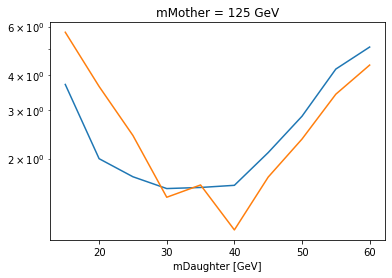

Looks good. Saving this to comb_LHC13_CMS_36.json


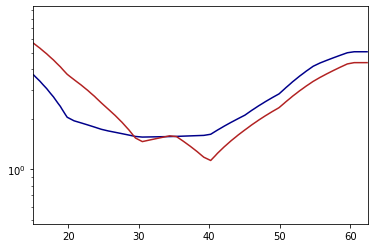

In [18]:
df = read_csv_from_web(
    "https://www.hepdata.net/download/table/ins1674926/Table1/1/csv",
    comment="#",
    skiprows=42,
    skipfooter=99 - 53,
    engine="python",
    names=["mDaughter1", "exp"],
)

dfObs = read_csv_from_web(
    "https://www.hepdata.net/download/table/ins1674926/Table1/1/csv",
    comment="#",
    skiprows=87,
    names=["m", "obs"],
)
assert np.allclose(df.mDaughter1, dfObs.m)
df["obs"] = dfObs.obs
del dfObs
df["mMother"] = 125

prodModes = ["H", "vbfH", "HZ", "HW"]
ref = HP.SMHiggs(125)
refCxn = np.sum([ref.cxn("LHC13", p) for p in prodModes])
df.obs *= refCxn
df.exp *= refCxn

limitFile = implementPairDecayLimit(
    "1805.10191",
    {
        "production": prodModes,
        "firstDecay": ["bb"],
        "secondDecay": ["tautau"],
    },
    "https://www.hepdata.net/record/ins1673011",
    df,
    massResolution={
        "firstDaughter": resolution.bb["medMass"],
        "secondDaughter": resolution.tautau["default"],
        "mother": {
            "absolute": 40,
            "relative": 0,
        },  # probably still bad due to neutrinos
    },
)
lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h2 = pred.addParticle(HP.NeutralScalar("h2"))
hh.setDecayWidth("h1", "h2", 1.0)
h1.setDecayWidth("tautau", 1.0)
h2.setDecayWidth("bb", 1.0)
hh.setMass(125)
hm = np.linspace(15, 62.5)
r = np.linspace(0.01, 0.2)


def testAgainstLimit(mass, rate):
    from math import sqrt

    h1.setMass(mass)
    h2.setMass(mass)
    HP.effectiveCouplingInput(hh, HP.scaledSMlikeEffCouplings(sqrt(rate)))
    hh.setDecayWidth("h2", "h1", 100)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r * refCxn, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r * refCxn, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")
plt.show()


## high mass `X > hSM hSM > bbtautau` [1808.01365](https://arxiv.org/abs/1808.01365)


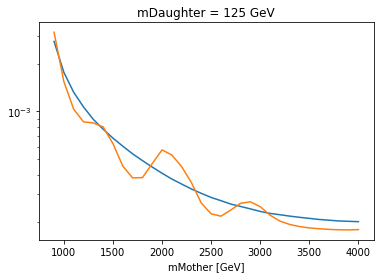

Looks good. Saving this to ggH_highM_LHC13_CMS_36.json


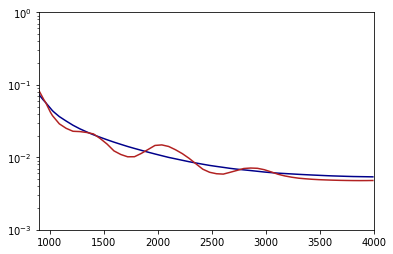

In [19]:
dfs = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins1685235/Figure%205a/1/csv"
)
df = dfs[0].rename(
    columns={
        "Radion mass [GeV]": "mMother",
        "Cross section upper limit at 95% CL [fb]": "obs",
    }
)
df["exp"] = dfs[1]["Cross section upper limit at 95% CL [fb]"]

df["mDaughter1"] = 125
refBr = HP.SMHiggs(125).br("bb") * HP.SMHiggs(125).br("tautau")
df.obs *= 1e-3 * refBr
df.exp *= 1e-3 * refBr

limitFile = implementPairDecayLimit(
    "1808.01365",
    {
        "production": ["ggH"],
        "firstDecay": ["bb"],
        "secondDecay": ["tautau"],
    },
    "https://doi.org/10.17182/hepdata.88169.v1/t1",
    df,
    massResolution={
        "firstDaughter": {
            "absolute": 35,
            "relative": 0,
        },  # guess
        "secondDaughter": {"absolute": 45, "relative": 0},  # guess
        "mother": {"absolute": 45, "relative": 7e-2},  # page 13
    },
    prefix="ggH_highM",
)
lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h2 = pred.addParticle(HP.NeutralScalar("h2"))
hh.setDecayWidth("h1", "h2", 1.0)
h1.setDecayWidth("tautau", 1.0)
h2.setDecayWidth("bb", 1.0)
h1.setMass(125)
h2.setMass(125)
hm = np.linspace(900, 4000)
r = np.linspace(1e-3, 1) * refBr


def testAgainstLimit(mass, rate):
    hh.setMass(mass)
    hh.setCxn("LHC13", "ggH", rate)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r / refBr, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r / refBr, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")


## `H > hSM hSM > bbtautau` [1707.02909](https://arxiv.org/abs/1707.02909)


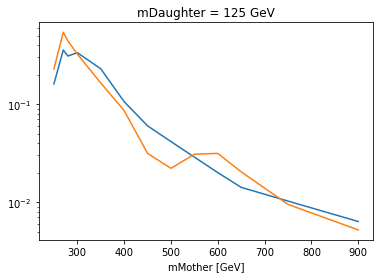

Looks good. Saving this to H_LHC13_CMS_36.json


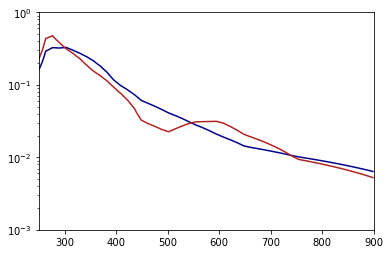

In [3]:
dfExp = read_csv_from_web(
    "https://www.hepdata.net/download/table/ins1609262/Table1/1/csv",
    comment="#",
    skiprows=21,
    skipfooter=51 - 35,
    engine="python",
    names=["m", "exp", "unc+", "unc-"],
)

df = read_csv_from_web(
    "https://www.hepdata.net/download/table/ins1609262/Table1/1/csv",
    comment="#",
    skiprows=36,
    names=["mMother", "obs"],
)
assert np.allclose(df.mMother, dfExp.m)
df["exp"] = dfExp.exp
df.exp *= 1e-3  # fb to pb
df.obs *= 1e-3  # fb to pb
df["mDaughter1"] = 125
limitFile = implementPairDecayLimit(
    "1707.02909",
    {
        "production": ["H"],
        "firstDecay": ["bb"],
        "secondDecay": ["tautau"],
    },
    "Fig. 5 (upper)",
    df,
    massResolution={
        "firstDaughter": {
            "absolute": 35,
            "relative": 0,
        },  # eq 1
        "secondDaughter": {"absolute": 45, "relative": 0},  # eq 1
        "mother": resolution.bb["highMass"],
    },
)
lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h2 = pred.addParticle(HP.NeutralScalar("h2"))
hh.setDecayWidth("h1", "h2", 1.0)
h1.setDecayWidth("tautau", 1.0)
h2.setDecayWidth("bb", 1.0)
h1.setMass(125)
h2.setMass(125)
hm = np.linspace(250, 900)
r = np.linspace(1e-3, 1)


def testAgainstLimit(mass, rate):
    hh.setMass(mass)
    hh.setCxn("LHC13", "ggH", rate)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")


## non-res `pp > hSM hSM > bbtautau` [1707.02909](https://arxiv.org/abs/1707.02909)


In [2]:
df = pd.DataFrame({"m": [125], "obs": 75.4e-3, "exp": 61.0e-3})
limitFile = implementPairProductionLimit(
    "1707.02909",
    {"firstDecay": ["bb"], "secondDecay": ["tautau"]},
    "p. 13",
    df,
    idSuffix=1,
    massResolution={  # guess +-20
        "firstParticle": {"absolute": 40, "relative": 0.0},
        "secondParticle": {"absolute": 40, "relative": 0.0},
    },
)

lim = HB.Limit(limitFile)

pred = Predictions()
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h1.setDecayWidth("bb", 1.0)
h1.setMass(125)
h2 = pred.addParticle(HP.NeutralScalar("h2"))
h2.setDecayWidth("tautau", 1.0)
h2.setMass(125)
pred.setBsmPairCxn("LHC13", "h1", "h2", 1.0)
res = lim.apply(pred)
print(res)
assert np.isclose(res[0].obsRatio(), 1.0 / df.obs[0])
assert np.isclose(res[0].expRatio(), 1.0 / df.exp[0])


Looks good. Saving this to nonres_LHC13_CMS_36.json
[<Higgs.bounds.AppliedLimit limitId: 1707029091, obsRatio: 13.263, expRatio: 16.393, for: ["h1", "+", "h2"]>]


## `H > hSM S > tautau bb` [2106.10361](http://arxiv.org/abs/2106.10361)
This is the first limit that covers substantial parameter space in two variable masses.

reading data for mH = 240 GeV...
reading data for mH = 280 GeV...
reading data for mH = 320 GeV...
reading data for mH = 360 GeV...
reading data for mH = 400 GeV...
reading data for mH = 450 GeV...
reading data for mH = 500 GeV...
reading data for mH = 550 GeV...
reading data for mH = 600 GeV...
reading data for mH = 700 GeV...
reading data for mH = 800 GeV...
reading data for mH = 900 GeV...
reading data for mH = 1000 GeV...
reading data for mH = 1200 GeV...
reading data for mH = 1400 GeV...
reading data for mH = 1600 GeV...
reading data for mH = 1800 GeV...
reading data for mH = 2000 GeV...
reading data for mH = 2500 GeV...
reading data for mH = 3000 GeV...
Looks good. Saving this to ggH_LHC13_CMS_137.json


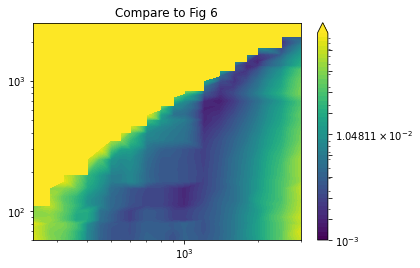

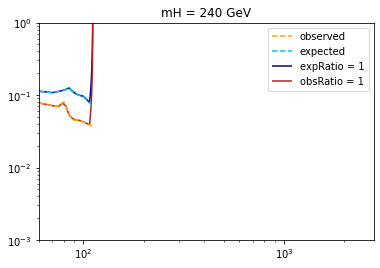

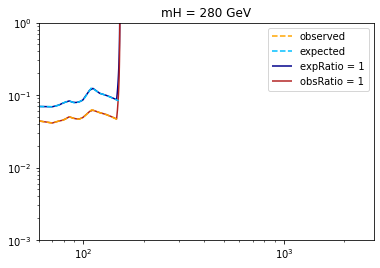

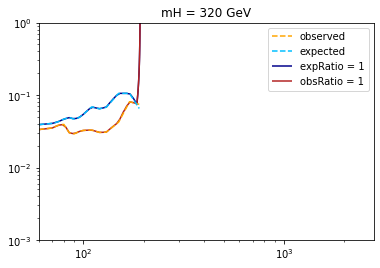

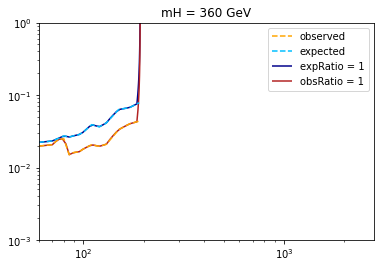

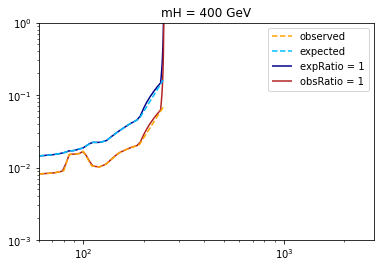

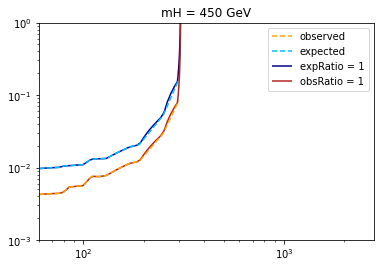

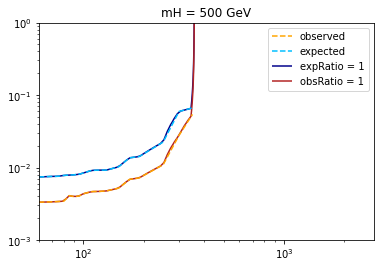

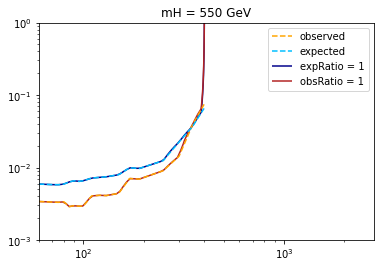

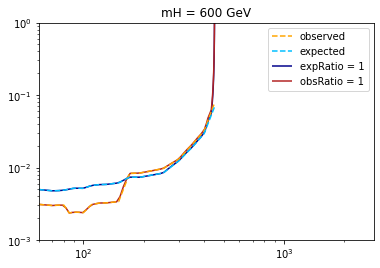

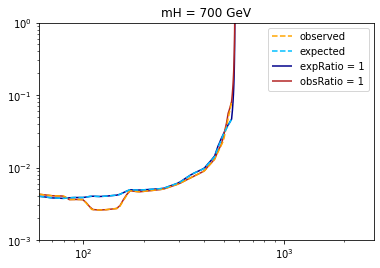

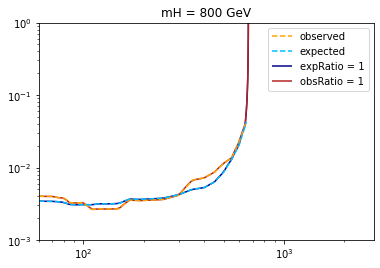

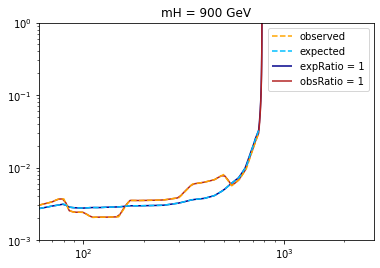

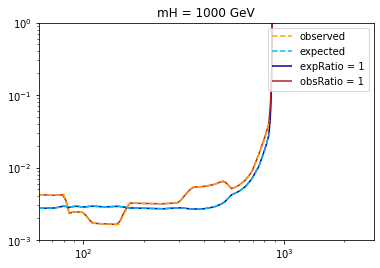

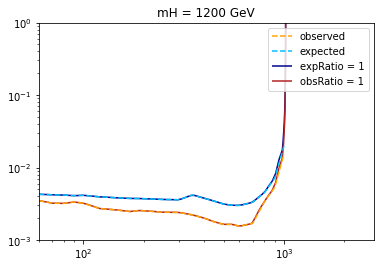

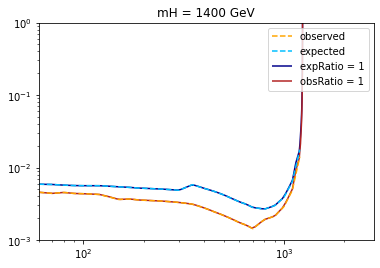

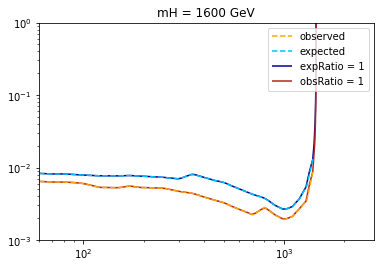

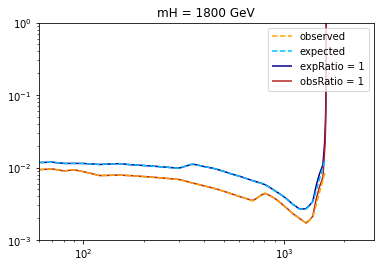

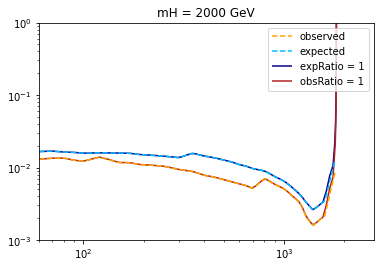

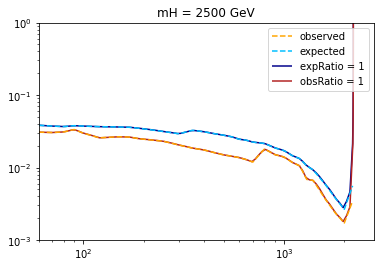

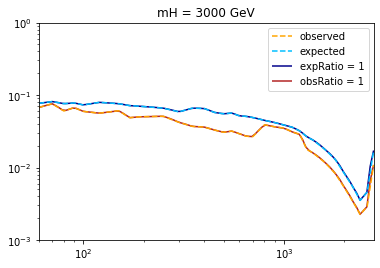

In [4]:
masses = np.concatenate(
    [
        np.arange(240, 400, 40),
        np.arange(400, 600, 50),
        np.arange(600, 1000, 100),
        np.arange(1000, 2000, 200),
        np.arange(2000, 3001, 500),
    ]
)
dfs = []
for m in masses:
    print("reading data for mH = {} GeV...".format(m))
    dfms = readHEPDataCsv(
        "https://www.hepdata.net/download/table/ins1869505/Exclusion%20limits%20for%20heavy%20higgs%20boson%20mass%20{}%20GeV/1/csv".format(
            m
        )
    )
    dfm = dfms[0].rename(
        columns={
            "Light Higgs boson mass [GeV]": "mDaughter2",
            "cross section x branching ratio upper limit at 95% CL [pb]": "obs",
        }
    )
    assert np.allclose(
        dfm.mDaughter2, dfms[1]["Light Higgs boson mass [GeV]"]
    ), "same mass grid for obs and exp"
    dfm["exp"] = dfms[1]["cross section x branching ratio upper limit at 95% CL [pb]"]
    dfm["mMother"] = m
    dfs.append(dfm)

commonMassGrid = np.unique(np.concatenate([df.mDaughter2 for df in dfs]))
dfsOnGrid = [
    pd.DataFrame({"mDaughter2": commonMassGrid}).merge(
        dfo, on="mDaughter2", how="outer"
    )
    for dfo in dfs
]
for m, df in zip(masses, dfsOnGrid):
    df["mMother"] = m
    df.set_index("mDaughter2", inplace=True)
    df.interpolate(method="index", limit_area="inside", inplace=True)
    df.reset_index(inplace=True)
df = pd.concat(dfsOnGrid)
df["mDaughter1"] = 125
df.fillna(1e6, inplace=True)

limitFile = implementPairDecayLimit(
    "2106.10361",
    {
        "production": ["ggH"],
        "firstDecay": ["tautau"],
        "secondDecay": ["bb"],
    },
    "https://doi.org/10.17182/hepdata.102794",
    df,
    massResolution={
        "firstDaughter": resolution.tautau["default"],
        "secondDaughter": resolution.bb["medMass"],
        "mother": resolution.bb["highMass"],
    },
)

from matplotlib.colors import LogNorm

plt.figure()
plt.title("Compare to Fig 6")
plt.tricontourf(
    df.mMother,
    df.mDaughter2,
    df.obs,
    norm=LogNorm(0.001, 0.1),
    extend="max",
    levels=np.logspace(-3, -1),
)
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.show()

lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h2 = pred.addParticle(HP.NeutralScalar("h2"))
hh.setDecayWidth("h1", "h2", 1.0)
h1.setDecayWidth("tautau", 1.0)
h2.setDecayWidth("bb", 1.0)
h1.setMass(125)
hm = np.logspace(np.log10(60), np.log10(2800), 100)
r = np.linspace(1e-3, 1)


def testAgainstLimit(mass, rate):
    h2.setMass(mass)
    hh.setCxn("LHC13", "ggH", rate)
    app = lim.apply(pred)
    if len(app) == 0:
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


for i, m in enumerate(masses):
    test = np.frompyfunc(testAgainstLimit, 2, 2)
    hh.setMass(m)
    XX, YY = np.meshgrid(hm, r)
    expR, obsR = test(XX, YY)
    fig, ax = plt.subplots()
    ax.set_yscale("log")
    expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
    obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
    expCc.collections[0].set_label("expRatio = 1")
    obsCc.collections[0].set_label("obsRatio = 1")
    ax.plot(
        dfs[i].mDaughter2,
        dfs[i].obs,
        ls="--",
        c="orange",
        label="observed",
    )
    ax.plot(
        dfs[i].mDaughter2,
        dfs[i].exp,
        ls="--",
        c="deepskyblue",
        label="expected",
    )
    ax.set_xscale("log")
    ax.set_title("mH = {} GeV".format(m))
    ax.legend()
    plt.show()


# CMS 8TeV LHC

## `H > hSM hSM > bbtautau` [1510.01181](https://arxiv.org/abs/1510.01181)


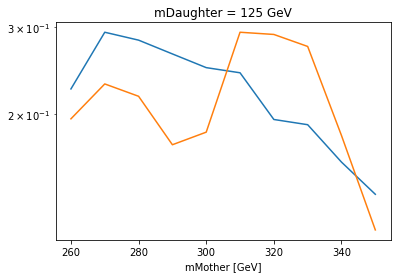

Looks good. Saving this to H_LHC8_CMS_20.json


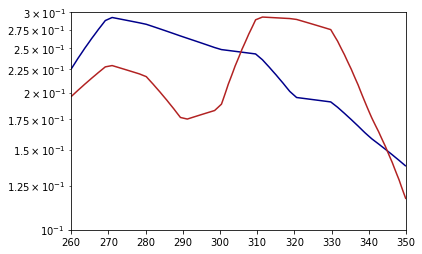

In [6]:
df = fromHB5Table1("140341_CMS_H-hh-bbtautau_19.7fb-1", "CMS").rename(
    columns={"m": "mMother"}
)
df["mDaughter1"] = 125
limitFile = implementPairDecayLimit(
    "1510.01181",
    {
        "production": ["H"],
        "firstDecay": ["bb"],
        "secondDecay": ["tautau"],
    },
    "Fig. 8 (bottom-right)",
    df,
    massResolution={
        "firstDaughter": {
            "absolute": 30,
            "relative": 0,
        },  # p.9 bottom (estimated on the smaller side)
        "secondDaughter": {"absolute": 30, "relative": 0},
        "mother": resolution.bb["highMass"],
    },
    idSuffix=1, # 2 is ZH
)
lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h2 = pred.addParticle(HP.NeutralScalar("h2"))
hh.setDecayWidth("h1", "h2", 1.0)
h1.setDecayWidth("tautau", 1.0)
h2.setDecayWidth("bb", 1.0)
h1.setMass(125)
h2.setMass(125)
hm = np.linspace(260, 350)
r = np.linspace(0.1, 0.3)


def testAgainstLimit(mass, rate):
    hh.setMass(mass)
    hh.setCxn("LHC8", "ggH", rate)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")
plt.show()
